In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
from hive_dataset import HiveDataset
from train import Train
from model import CNNModel

In [3]:
# Allow imports from the src directory
import sys
import os
from pathlib import Path
sys.path.append(
    str(Path(os.path.dirname(os.path.abspath(os.path.abspath('')))).parents[0]))
import config

In [4]:
metadata = np.load(config.PROCESSED_METADATA_FILE_SEGMENTED, allow_pickle=True)

metadata_column_names = ['sample_name', "label", "hive_number", "segment",]
metadata_df = pd.DataFrame(metadata, columns=metadata_column_names)

metadata_df.head()

,sample_name,label,hive_number,segment
0,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment0
1,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment1
2,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment2
3,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment3
4,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment4


## Training auf allen Daten

In [13]:
trainer = Train(CNNModel(), nn.BCELoss())

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            1,130,560
├─Linear: 1-8                            65
Total params: 1,227,777
Trainable params: 1,227,777
Non-trainable params: 0


In [ ]:
trainer.train_cnn(epochs=20)

In [14]:
model_name = 'model_20240920_161533_0'

checkpoint_path = '../../models/interim/' + model_name + '_checkpoint.pt'
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer.load_model(checkpoint_path, model, optimizer)

In [8]:
torch.onnx.export(model, next(iter(trainer.training_dataloader))[0], model_name + "_CNN.onnx", input_names=["MEL-Spectrograms"], output_names=["predictions"])

In [15]:
model_loaded

CNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=17664, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [16]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [17]:
start_epoch

0

In [18]:
train_samples, val_samples, test_samples

(array(['Hive1 31_05_2018_NO_QueenBee____00_50_00',
        'Hive1 12_06_2018_QueenBee____20_40_00',
        'Hive3_28_07_2017_QueenBee____00_00_00',
        'Hive1 31_05_2018_NO_QueenBee____09_00_00',
        'Hive1 31_05_2018_NO_QueenBee____20_30_00',
        'Hive3_28_07_2017_QueenBee____03_20_00',
        'Hive3_28_07_2017_QueenBee____04_10_00',
        'Hive3_14_07_2017_NO_QueenBee____22_40_00',
        'Hive3_14_07_2017_NO_QueenBee____08_10_00',
        'Hive3_28_07_2017_QueenBee____16_20_00',
        'Hive3_28_07_2017_QueenBee____22_10_00',
        'Hive1 12_06_2018_QueenBee____19_00_00',
        'Hive1 12_06_2018_QueenBee____23_30_00',
        'Hive3_28_07_2017_QueenBee____21_20_00',
        'Hive1 12_06_2018_QueenBee____01_10_00',
        'Hive3_28_07_2017_QueenBee____09_00_00',
        'Hive1 12_06_2018_QueenBee____03_10_00',
        'Hive1 31_05_2018_NO_QueenBee____04_50_00',
        'Hive3_14_07_2017_NO_QueenBee____21_40_00',
        'Hive1 12_06_2018_QueenBee____09_20_00',

In [19]:
model = model_loaded

In [20]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cpu.


100%|██████████| 27/27 [00:38<00:00,  1.42s/it]

torch.Size([860])


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted', ylabel='Actual'>

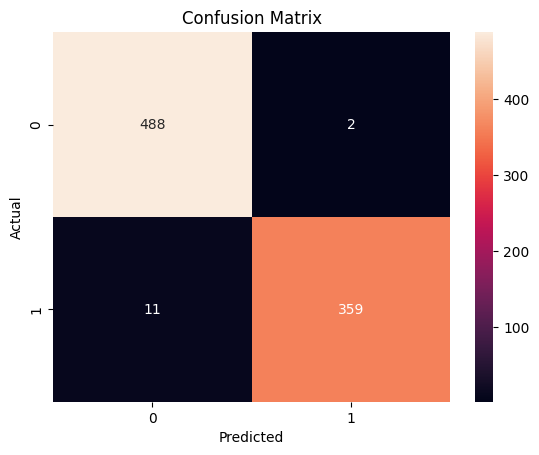

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix")
plt

In [16]:
from sklearn.metrics import classification_report

print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       490
         1.0       0.99      0.97      0.98       370

    accuracy                           0.98       860
   macro avg       0.99      0.98      0.98       860
weighted avg       0.99      0.98      0.98       860



## Hive-Indepentent

In [5]:
trainer_hive_independent = Train(CNNModel(), nn.BCELoss(), training_hive=1)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            1,130,560
├─Linear: 1-8                            65
Total params: 1,227,777
Trainable params: 1,227,777
Non-trainable params: 0


In [ ]:
trainer_hive_independent.train_cnn(epochs=20)

In [7]:
model_name = 'model_20240920_170733_0'

checkpoint_path = '../../models/interim/' + model_name + '_checkpoint.pt'
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer_hive_independent.load_model(checkpoint_path, model, optimizer)

In [8]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer_hive_independent.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cpu.


100%|██████████| 90/90 [02:23<00:00,  1.59s/it]

torch.Size([2849])


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted', ylabel='Actual'>

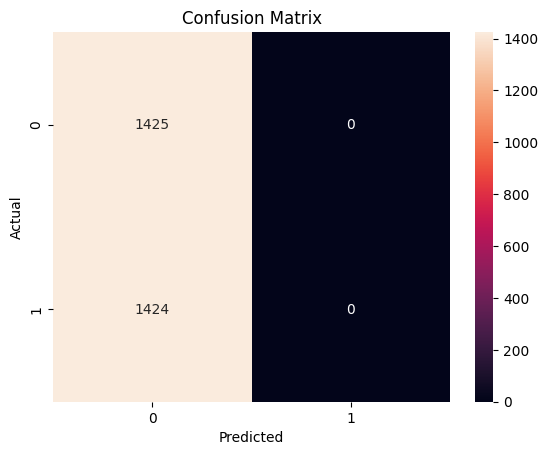

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix")
plt